# Mini-GPT Training Implementation

## Assignment 2: Transformer Language Model

**Student ID**: [Your ID]  
**Name**: [Your Name]  

### Objective
Implement and train a small-scale transformer model (mini-GPT) for next-token prediction using PyTorch.

In [21]:
# Install required packages
!pip install matplotlib
!pip install tqdm


[notice] A new release of pip is available: 23.2.1 -> 25.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 25.2
[notice] To update, run: pip install --upgrade pip


In [22]:
# Import necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn import functional as F
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm 

# Set random seed for reproducibility
torch.manual_seed(42)
print("Libraries imported successfully")

Libraries imported successfully


## 1. Data Loading and Preparation

Load the preprocessed dataset from Assignment 1 and prepare it for training.

In [23]:
import os

def convert_utf16_zip_to_standard(input_path, output_path):
    """将UTF-16编码的ZIP文件转换为标准ZIP格式"""
    with open(input_path, 'rb') as f:
        content = f.read()
    
    # 移除UTF-16的BOM头 (FE FF) 并重新编码
    if content.startswith(b'\xfe\xff'):
        # 将UTF-16BE转换为UTF-8
        utf16_content = content.decode('utf-16be')
        standard_content = utf16_content.encode('utf-8')
        
        with open(output_path, 'wb') as f:
            f.write(standard_content)
        print(f"转换成功！标准文件已保存为: {output_path}")
    else:
        print("文件不是UTF-16编码的ZIP文件")

# 使用示例
convert_utf16_zip_to_standard('sample_dataset.pt', 'fixed_dataset.zip')

文件不是UTF-16编码的ZIP文件


In [24]:
import zipfile

try:
    with zipfile.ZipFile('fixed_dataset.zip', 'r') as zip_ref:
        zip_ref.extractall('extracted_data')
        print("解压成功！内容在 extracted_data/ 目录")
        print("解压出的文件:", os.listdir('extracted_data'))
except Exception as e:
    print("解压失败:", e)

解压失败: [Errno 2] No such file or directory: 'fixed_dataset.zip'


In [25]:
# Load the dataset from previous assignment
# Use weights_only=False for compatibility with our data format
batches = torch.load('sample_dataset.pt', weights_only=False)
print(f"Number of batches saved: {len(batches)}")
print(f"Single batch structure: {batches[0].keys()}")
print(f"Input IDs shape in one batch: {batches[0]['input_ids'].shape}")

# Extract all input_ids and flatten for sequence training
all_input_ids = torch.cat([batch['input_ids'] for batch in batches], dim=0)
print(f"All input IDs shape: {all_input_ids.shape}")

# Calculate vocabulary size (crucial parameter)
vocab_size = batches[0]['input_ids'].max().item() + 1
print(f"Vocabulary size: {vocab_size}")

Number of batches saved: 5
Single batch structure: dict_keys(['input_ids', 'attention_mask'])
Input IDs shape in one batch: torch.Size([32, 512])
All input IDs shape: torch.Size([160, 512])
Vocabulary size: 29877


In [26]:
# Hyperparameters for data preparation
batch_size = 32
block_size = 64  # Sequence length (within 32-128 range as required)
split_ratio = 0.9  # Train/validation split

# Use first 'block_size' tokens from each sequence and flatten
data = all_input_ids[:, :block_size].flatten()
print(f"Final training data shape: {data.shape}")

# Split into training and validation sets
n = int(split_ratio * len(data))
train_data = data[:n]
val_data = data[n:]
print(f"Training samples: {len(train_data)}, Validation samples: {len(val_data)}")

Final training data shape: torch.Size([10240])
Training samples: 9216, Validation samples: 1024


In [27]:
def get_batch(split):
    """Get a batch of training or validation data"""
    data_source = train_data if split == 'train' else val_data
    ix = torch.randint(len(data_source) - block_size, (batch_size,))
    x = torch.stack([data_source[i:i+block_size] for i in ix])
    y = torch.stack([data_source[i+1:i+block_size+1] for i in ix])
    return x, y

# Test the batch generation
x_batch, y_batch = get_batch('train')
print(f"Input batch shape: {x_batch.shape}")
print(f"Target batch shape: {y_batch.shape}")

Input batch shape: torch.Size([32, 64])
Target batch shape: torch.Size([32, 64])


## 2. Model Implementation

Implement the mini-GPT transformer architecture as specified in requirements.

In [28]:
class MiniGPT(nn.Module):
    """Small-scale transformer model for next-token prediction"""
    
    def __init__(self, vocab_size, d_model=128, nhead=4, num_layers=2):
        super().__init__()
        self.d_model = d_model
        
        # Token and positional embeddings
        self.token_embedding = nn.Embedding(vocab_size, d_model)
        self.pos_embedding = nn.Embedding(block_size, d_model)
        
        # Transformer encoder layers
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=4*d_model,
            dropout=0.1,
            activation='gelu',
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        
        # Final layer normalization and output projection
        self.ln_f = nn.LayerNorm(d_model)
        self.lm_head = nn.Linear(d_model, vocab_size)
        
    def forward(self, idx):
        B, T = idx.shape
        
        # Token embeddings + positional embeddings
        tok_emb = self.token_embedding(idx)
        pos = torch.arange(0, T, dtype=torch.long, device=idx.device)
        pos_emb = self.pos_embedding(pos)
        x = tok_emb + pos_emb
        
        # Transformer processing
        x = self.transformer(x)
        
        # Output projection
        x = self.ln_f(x)
        logits = self.lm_head(x)
        
        return logits

# Instantiate the model
model = MiniGPT(vocab_size, d_model=128, nhead=4, num_layers=2)
print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")

Model parameters: 8,083,381


## 3. Training Setup

Configure training hyperparameters, optimizer, and loss function.

In [29]:
# Training hyperparameters (experiment with these values)
learning_rate = 5e-4
max_epochs = 5000
eval_interval = 500
eval_iters = 200

# Device configuration
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")
model = model.to(device)

# Optimizer and loss function
optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

# Lists to track training progress
train_losses = []
val_losses = []
val_ppls = []  # Perplexity = exp(loss)

Using device: cpu


In [30]:
@torch.no_grad()
def estimate_loss():
    """Estimate loss on both training and validation sets"""
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            X, Y = X.to(device), Y.to(device)
            logits = model(X)
            loss = criterion(logits.view(-1, vocab_size), Y.view(-1))
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

## 4. Training Loop

Execute the main training process with periodic evaluation.

In [31]:
# Main training loop
model.train()
progress_bar = tqdm(range(max_epochs), desc="Training")

for epoch in progress_bar:
    # Get training batch
    xb, yb = get_batch('train')
    xb, yb = xb.to(device), yb.to(device)
    
    # Forward pass
    logits = model(xb)
    loss = criterion(logits.view(-1, vocab_size), yb.view(-1))
    
    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    # Periodic evaluation
    if epoch % eval_interval == 0 or epoch == max_epochs - 1:
        losses = estimate_loss()
        train_loss = losses['train']
        val_loss = losses['val']
        val_ppl = torch.exp(torch.tensor(val_loss)).item()
        
        # Record metrics
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        val_ppls.append(val_ppl)
        
        # Update progress bar
        progress_bar.set_description(
            f"Epoch {epoch:5d} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val PPL: {val_ppl:.2f}"
        )

print("Training completed!")

Training:   0%|          | 0/5000 [00:00<?, ?it/s]/var/folders/qs/jk96t6013215v55nymj4qs4m0000gn/T/ipykernel_94733/3224837991.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_ppl = torch.exp(torch.tensor(val_loss)).item()
Epoch  4999 | Train Loss: 0.0063 | Val Loss: 4.7081 | Val PPL: 110.84: 100%|██████████| 5000/5000 [22:08<00:00,  3.76it/s]    

Training completed!


## 5. Model Saving and Visualization

Save the trained model checkpoint and generate training curves.

In [32]:
# Save model checkpoint
checkpoint = {
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'train_losses': train_losses,
    'val_losses': val_losses,
    'val_ppls': val_ppls,
    'config': {
        'vocab_size': vocab_size,
        'd_model': 128,
        'nhead': 4,
        'num_layers': 2,
        'block_size': block_size,
        'batch_size': batch_size,
        'learning_rate': learning_rate
    }
}

torch.save(checkpoint, 'mini_gpt_checkpoint.pt')
print("Model checkpoint saved to 'mini_gpt_checkpoint.pt'")

Model checkpoint saved to 'mini_gpt_checkpoint.pt'


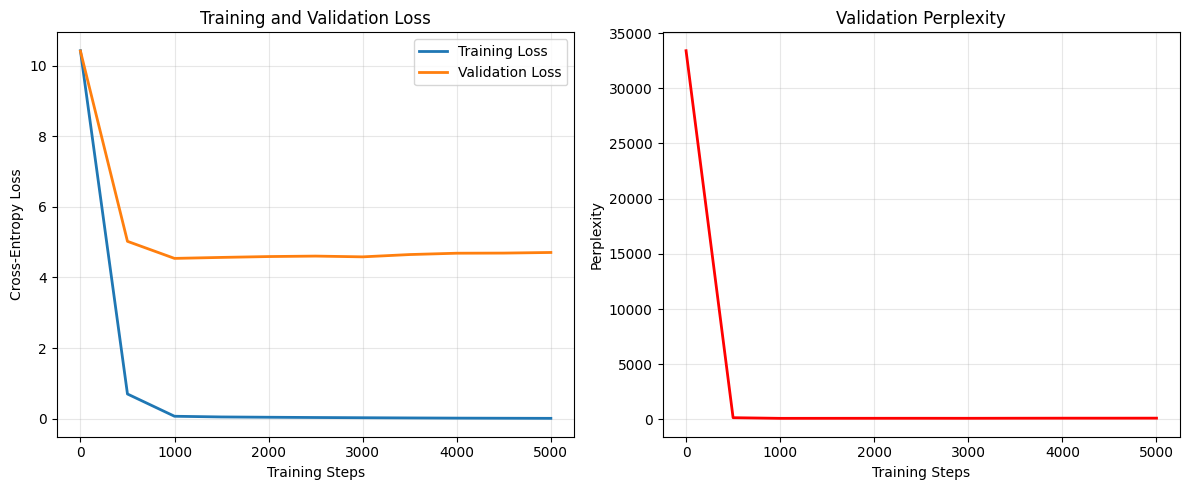

Training curves saved to 'training_curves.png'


In [33]:
# Generate training visualization
plt.figure(figsize=(12, 5))

# Loss curves
plt.subplot(1, 2, 1)
epochs_x = [i * eval_interval for i in range(len(train_losses))]
plt.plot(epochs_x, train_losses, label='Training Loss', linewidth=2)
plt.plot(epochs_x, val_losses, label='Validation Loss', linewidth=2)
plt.xlabel('Training Steps')
plt.ylabel('Cross-Entropy Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True, alpha=0.3)

# Perplexity curve
plt.subplot(1, 2, 2)
plt.plot(epochs_x, val_ppls, color='red', linewidth=2)
plt.xlabel('Training Steps')
plt.ylabel('Perplexity')
plt.title('Validation Perplexity')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('training_curves.png', dpi=300, bbox_inches='tight')
plt.show()

print("Training curves saved to 'training_curves.png'")

## 6. Model Loading Demonstration

Example code for loading the trained model checkpoint.

In [34]:
def load_model(checkpoint_path):
    """Load a trained model from checkpoint"""
    checkpoint = torch.load(checkpoint_path, map_location=device)
    
    # Recreate model architecture
    config = checkpoint['config']
    model = MiniGPT(
        vocab_size=config['vocab_size'],
        d_model=config['d_model'],
        nhead=config['nhead'],
        num_layers=config['num_layers']
    ).to(device)
    
    # Load trained weights
    model.load_state_dict(checkpoint['model_state_dict'])
    
    return model, checkpoint

# Example usage:
# loaded_model, checkpoint_info = load_model('mini_gpt_checkpoint.pt')
# print("Model loaded successfully!")

## 7. Hyperparameter Experimentation Guide

Experiment with different hyperparameters as required:

In [35]:
# ==================== EXPERIMENT RUNNER ====================
def run_experiment(exp_name, learning_rate, batch_size, d_model, num_layers, max_epochs=2000):
    """运行单个实验并自动保存结果"""
    print(f"\n=== Starting Experiment: {exp_name} ===")
    print(f"LR: {learning_rate}, BS: {batch_size}, d_model: {d_model}, layers: {num_layers}")
    
    # 重新初始化模型和优化器（重要！）
    model = MiniGPT(vocab_size, d_model=d_model, nhead=4, num_layers=num_layers).to(device)
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
    
    # 重置记录列表
    train_losses, val_losses, val_ppls = [], [], []
    
    # 训练循环（和之前一样，但使用新的超参数）
    model.train()
    for epoch in tqdm(range(max_epochs), desc=exp_name):
        xb, yb = get_batch('train')
        xb, yb = xb.to(device), yb.to(device)
        
        logits = model(xb)
        loss = criterion(logits.view(-1, vocab_size), yb.view(-1))
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if epoch % 200 == 0:  # 每200步评估一次
            losses = estimate_loss()
            train_loss = losses['train']
            val_loss = losses['val']
            val_ppl = torch.exp(torch.tensor(val_loss)).item()
            
            train_losses.append(train_loss)
            val_losses.append(val_loss)
            val_ppls.append(val_ppl)
    
    # 自动保存实验结果
    checkpoint = {
        'exp_name': exp_name,
        'config': {'lr': learning_rate, 'bs': batch_size, 'd_model': d_model, 'layers': num_layers},
        'train_losses': train_losses,
        'val_losses': val_losses,
        'val_ppls': val_ppls,
        'model_state': model.state_dict()
    }
    
    torch.save(checkpoint, f'experiment_{exp_name}.pt')
    print(f"Experiment {exp_name} completed and saved!")
    
    return checkpoint

# ==================== 运行多个实验 ====================
experiments = [
    # (实验名称, 学习率, 批大小, 模型维度, 层数)
    ('baseline', 5e-4, 32, 128, 2),
    ('large_model', 5e-4, 32, 256, 2),
    ('high_lr', 1e-3, 32, 128, 2),
    ('small_bs', 5e-4, 16, 128, 2),
    ('deep', 5e-4, 32, 128, 1),  # 只有1层
]

results = {}
for exp_config in experiments:
    name, lr, bs, dm, layers = exp_config
    results[name] = run_experiment(name, lr, bs, dm, layers)


=== Starting Experiment: baseline ===
LR: 0.0005, BS: 32, d_model: 128, layers: 2


baseline:   0%|          | 0/2000 [00:00<?, ?it/s]/var/folders/qs/jk96t6013215v55nymj4qs4m0000gn/T/ipykernel_94733/3195995918.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_ppl = torch.exp(torch.tensor(val_loss)).item()
baseline: 100%|██████████| 2000/2000 [11:29<00:00,  2.90it/s]  


Experiment baseline completed and saved!

=== Starting Experiment: large_model ===
LR: 0.0005, BS: 32, d_model: 256, layers: 2


large_model: 100%|██████████| 2000/2000 [13:39<00:00,  2.44it/s]  


Experiment large_model completed and saved!

=== Starting Experiment: high_lr ===
LR: 0.001, BS: 32, d_model: 128, layers: 2


high_lr: 100%|██████████| 2000/2000 [11:41<00:00,  2.85it/s]  


Experiment high_lr completed and saved!

=== Starting Experiment: small_bs ===
LR: 0.0005, BS: 16, d_model: 128, layers: 2


small_bs: 100%|██████████| 2000/2000 [11:36<00:00,  2.87it/s]  


Experiment small_bs completed and saved!

=== Starting Experiment: deep ===
LR: 0.0005, BS: 32, d_model: 128, layers: 1


deep: 100%|██████████| 2000/2000 [10:59<00:00,  3.03it/s]  


Experiment deep completed and saved!


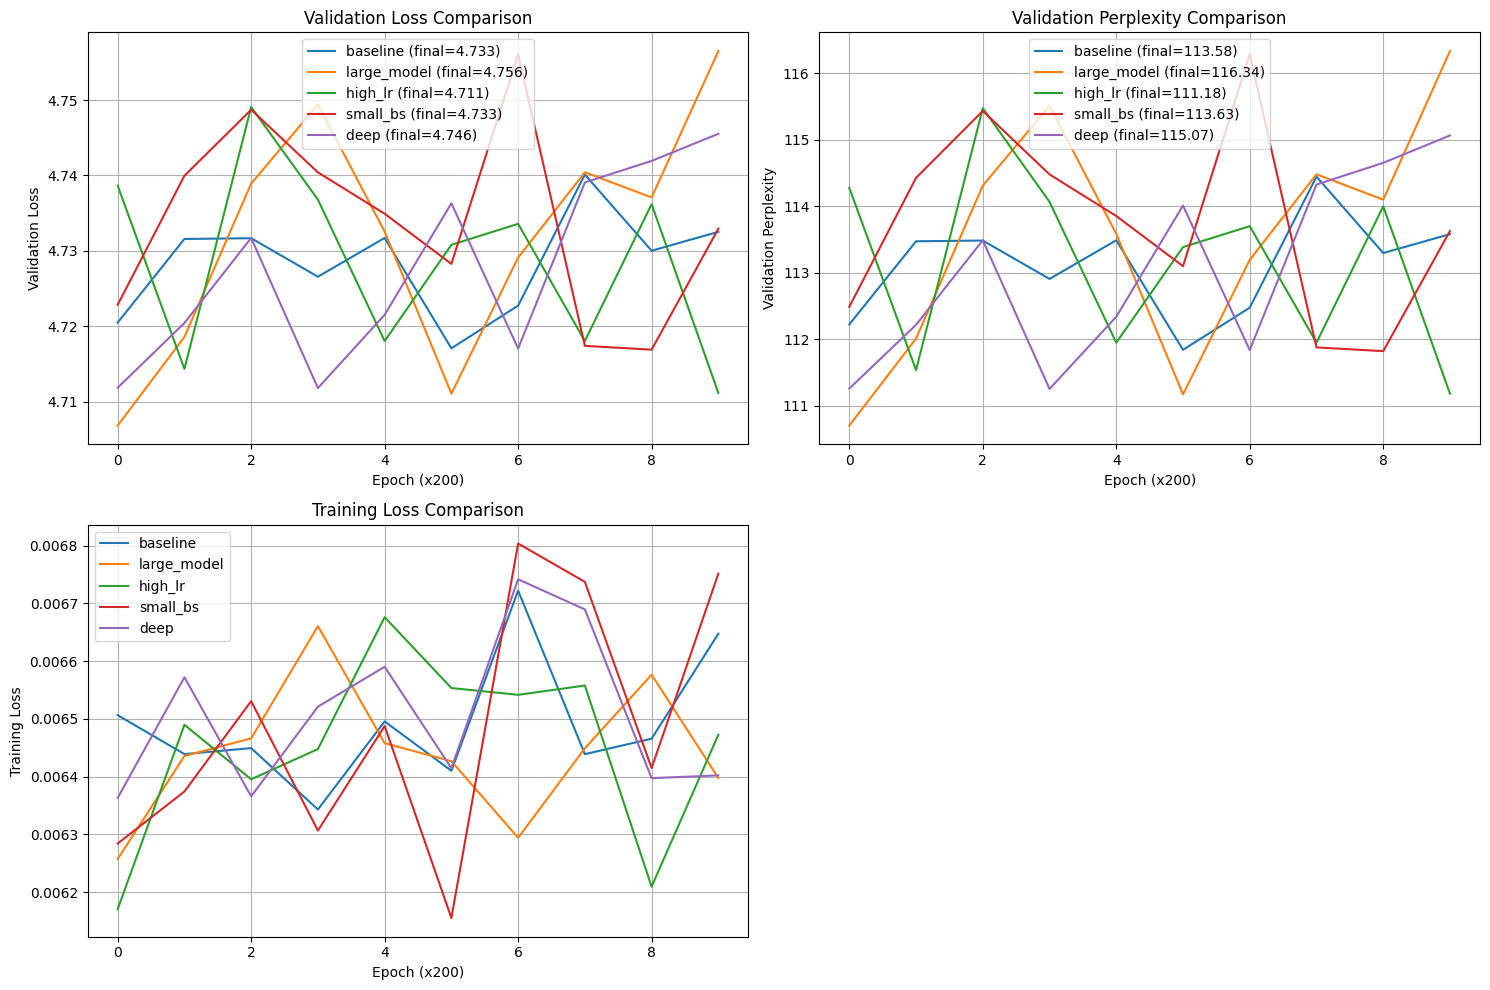

=== Final Results Summary ===
Experiment | Val Loss | Val PPL | Config
-----------|----------|---------|--------
baseline   |    4.733 |  113.58 | LR=0.0005, BS=32, d_model=128, layers=2
large_model |    4.756 |  116.34 | LR=0.0005, BS=32, d_model=256, layers=2
high_lr    |    4.711 |  111.18 | LR=0.001, BS=32, d_model=128, layers=2
small_bs   |    4.733 |  113.63 | LR=0.0005, BS=16, d_model=128, layers=2
deep       |    4.746 |  115.07 | LR=0.0005, BS=32, d_model=128, layers=1


In [36]:
# ==================== 可视化比较所有实验 ====================
plt.figure(figsize=(15, 10))

# 加载所有实验结果
all_results = {}
for exp_name in ['baseline', 'large_model', 'high_lr', 'small_bs', 'deep']:
    try:
        all_results[exp_name] = torch.load(f'experiment_{exp_name}.pt')
    except:
        print(f"Could not load {exp_name}")

# 绘制验证损失比较
plt.subplot(2, 2, 1)
for name, res in all_results.items():
    plt.plot(res['val_losses'], label=f"{name} (final={res['val_losses'][-1]:.3f})")
plt.xlabel('Epoch (x200)')
plt.ylabel('Validation Loss')
plt.title('Validation Loss Comparison')
plt.legend()
plt.grid(True)

# 绘制验证困惑度比较
plt.subplot(2, 2, 2)
for name, res in all_results.items():
    plt.plot(res['val_ppls'], label=f"{name} (final={res['val_ppls'][-1]:.2f})")
plt.xlabel('Epoch (x200)')
plt.ylabel('Validation Perplexity')
plt.title('Validation Perplexity Comparison')
plt.legend()
plt.grid(True)

# 绘制训练损失比较
plt.subplot(2, 2, 3)
for name, res in all_results.items():
    plt.plot(res['train_losses'], label=name)
plt.xlabel('Epoch (x200)')
plt.ylabel('Training Loss')
plt.title('Training Loss Comparison')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig('all_experiments_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# 打印最终结果表格
print("=== Final Results Summary ===")
print("Experiment | Val Loss | Val PPL | Config")
print("-----------|----------|---------|--------")
for name, res in all_results.items():
    config = res['config']
    print(f"{name:10} | {res['val_losses'][-1]:8.3f} | {res['val_ppls'][-1]:7.2f} | "
          f"LR={config['lr']}, BS={config['bs']}, d_model={config['d_model']}, layers={config['layers']}")